In [1]:
import sys
sys.path.append('../../../')
sys.path.append('../../')
sys.path.append('../')
import seaborn as sns 
from multiprocessing import Process
from omegaconf import OmegaConf
from core.run_lib import *
import numpy as np 
from core.passive_learning import *
from core.auto_labeling import *
from datasets import dataset_factory 
from datasets.dataset_utils import * 
from utils.common_utils import * 
from utils.vis_utils import *
from core.run_lib import * 
import copy 
import random 
from datasets.numpy_dataset import * 


root_dir = '../../../'
conf_dir = f'{root_dir}configs/calib-exp/'

base_conf_file = '{}/mnist_lenet_base_conf.yaml'.format(conf_dir)
root_pfx = 'mnist_lenet_calib-exp-runs'
root_pfx = f'{root_dir}/outputs/{root_pfx}/'


lst_seed_frac= [0.2]
lst_query_batch_frac = [0.05]


conf = OmegaConf.load(base_conf_file)
conf['root_pfx']    = root_pfx


logger   = get_logger('../../../temp/logs/act_lbl_test.log',stdout_redirect=True,level=logging.DEBUG)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
conf['train_pts_query_conf']['seed_train_size']= 10 
conf['train_pts_query_conf']['max_num_train_pts']= 50

set_seed(conf['random_seed'])

dm = DataManager(conf,logger,lib=conf['model_conf']['lib'])
len(dm.ds_std_train), len(dm.ds_std_val)

pl = PassiveLearning(conf,dm,logger)

out = pl.run()

w = pl.cur_clf.get_weights()
print(torch.norm(w))
test_err = get_test_error(pl.cur_clf,dm.ds_std_test,conf['inference_conf'])
print(test_err)

[09/10/2023 11:31:54 PM : DEBUG : data_manag : ] : torch.Size([42000, 28, 28])
[09/10/2023 11:31:54 PM : INFO  : data_manag : ] : Loaded dataset mnist
[09/10/2023 11:31:54 PM : INFO  : data_manag : ] : Std train size: 42000 and Std. Val. Size:18000
[09/10/2023 11:31:54 PM : DEBUG : passive_le : ] : Querying 10 seed training points
[09/10/2023 11:31:54 PM : DEBUG : passive_le : ] : Queried 10 seed points for training
[09/10/2023 11:31:54 PM : DEBUG : passive_le : ] : Validation Data Size :5000
[09/10/2023 11:31:54 PM : DEBUG : passive_le : ] : Querying rest of the training points 40 in single batch
[09/10/2023 11:31:54 PM : INFO  : passive_le : ] : Labeled data size for training: 50
[09/10/2023 11:31:54 PM : INFO  : pytorch_cl : ] : {'model_name': 'lenet', 'num_classes': 10, 'fit_intercept': True, 'lib': 'pytorch'}
[09/10/2023 11:31:54 PM : INFO  : passive_le : ] : --------------- Begin Model Training ------------
[09/10/2023 11:31:54 PM : INFO  : passive_le : ] : Training conf :{'optim

In [3]:
from calibration.calibrators import * 
import calibration.calibrators as calibrators

conf['calibrate_clf'] = True 
calib_train_conf = {} 

scaling_binning_base_conf = OmegaConf.load(
    f'{conf_dir}/post-hoc/beta_base_conf.yaml')
conf['calibration_conf'] = scaling_binning_base_conf

calib = calibrators.get_calibrator(clf=pl.cur_clf,calib_conf=scaling_binning_base_conf,logger=logger)

cur_val_ds,cur_val_idcs    = dm.get_current_validation_data()

calib.fit(cur_val_ds)
#logger.close()
close_logger(logger)

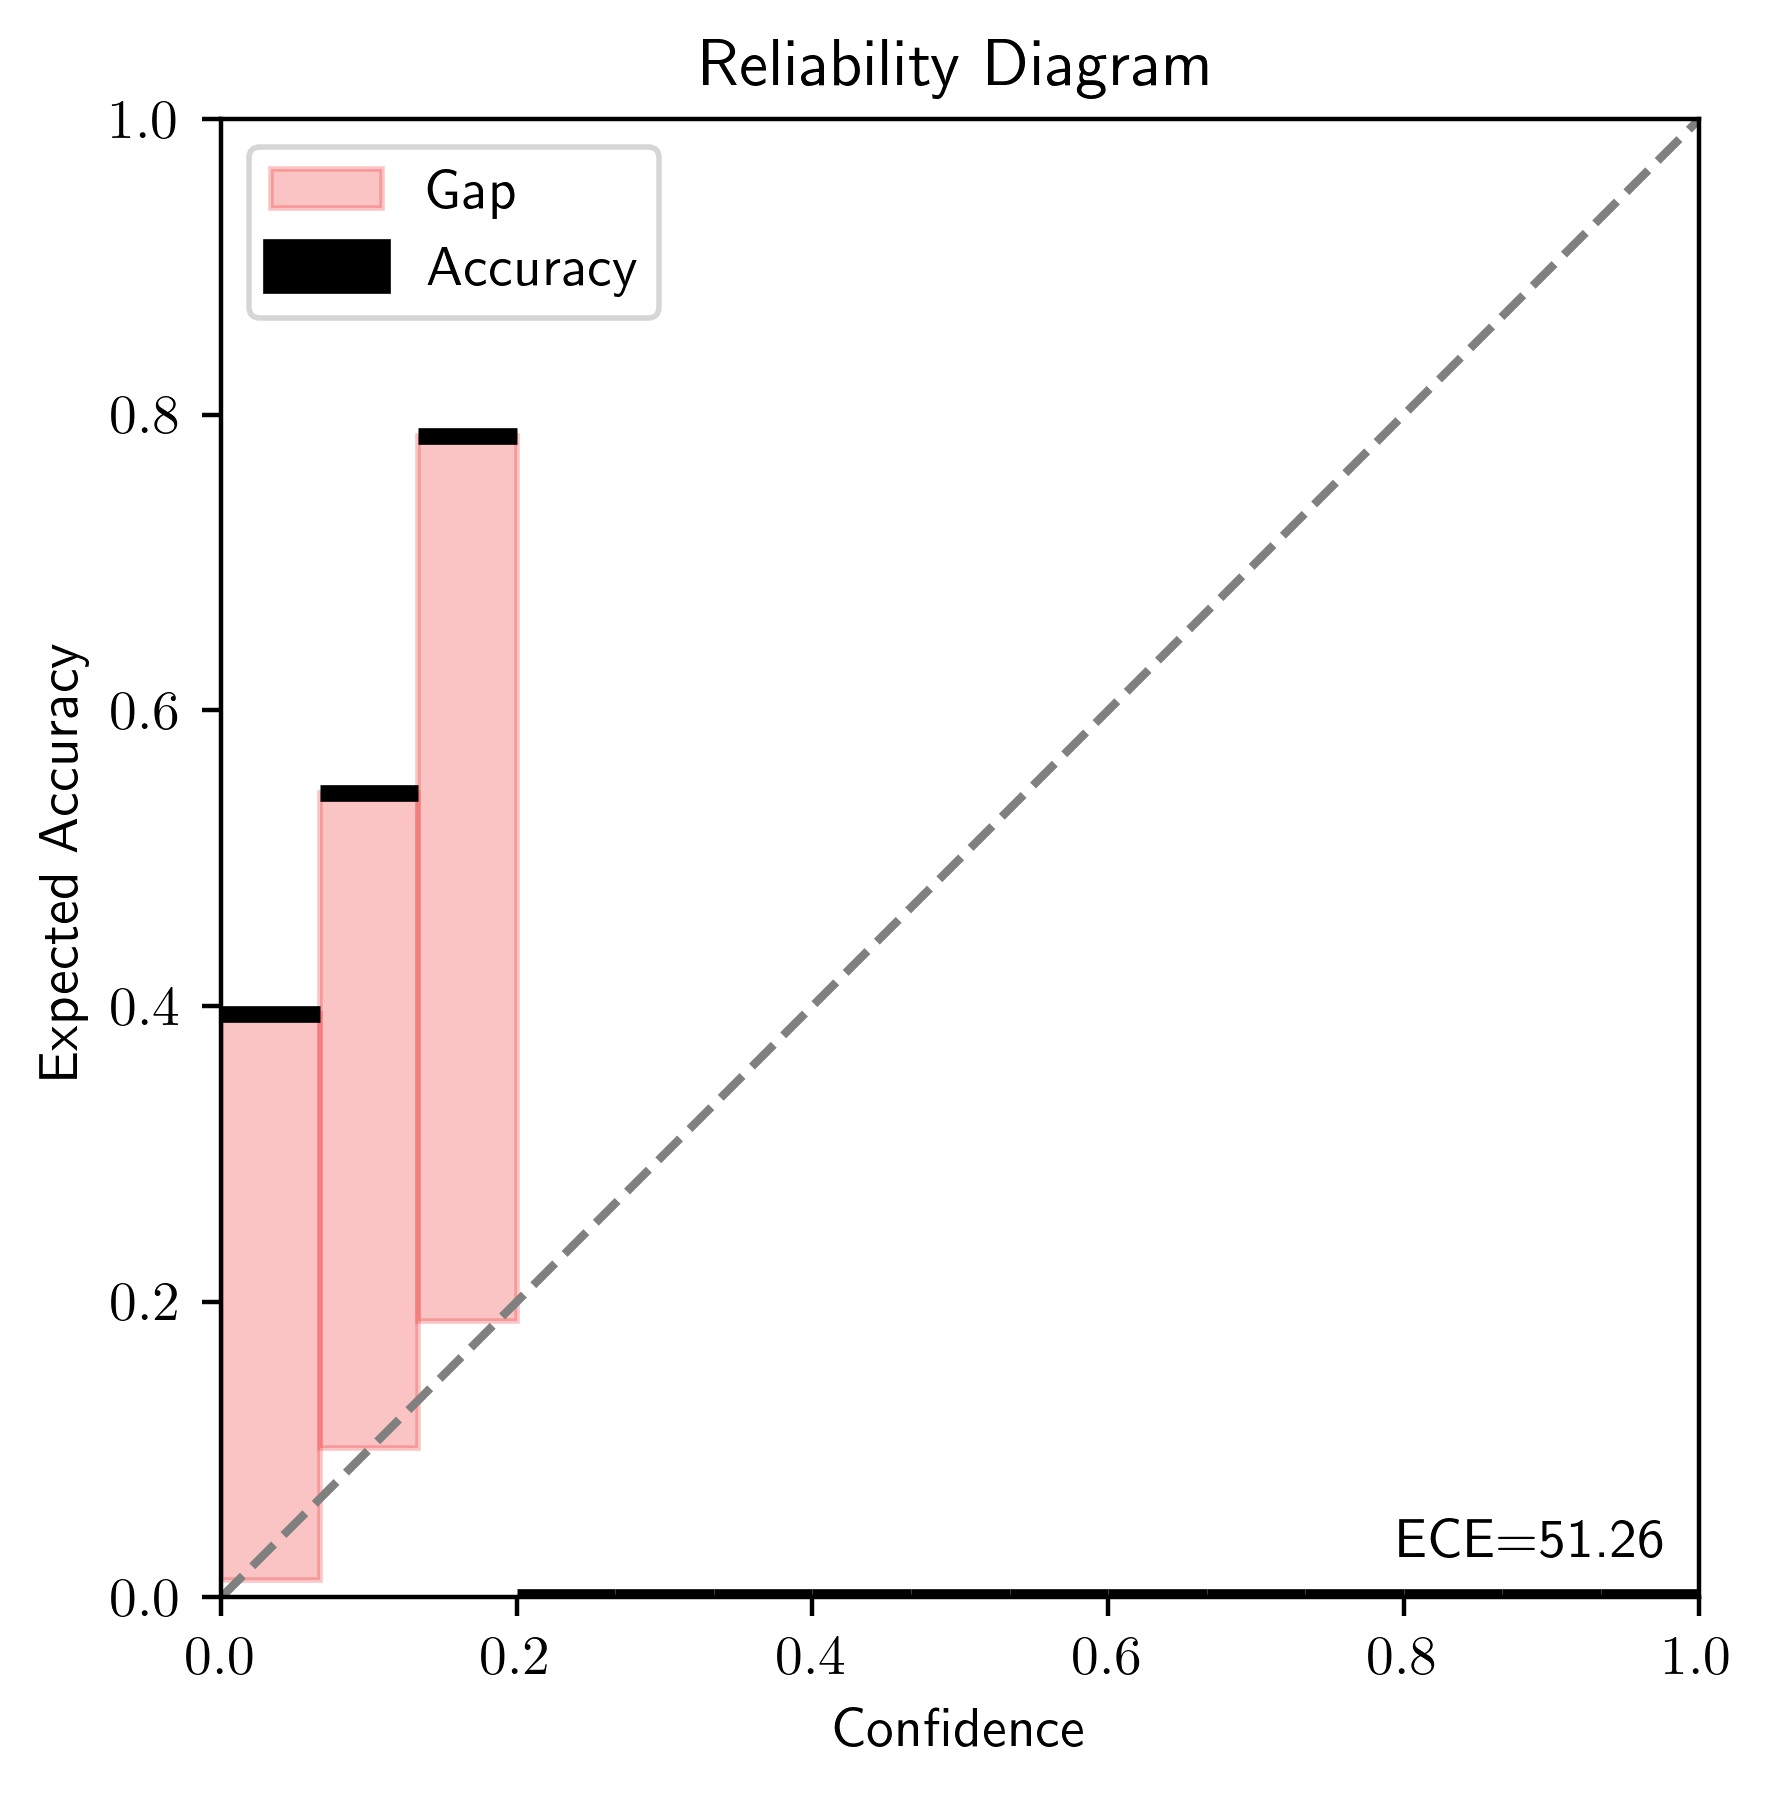

In [4]:
val_inf_out  = calib.predict(cur_val_ds,inference_conf={"device": "mps"})
bin_data = compute_calibration(cur_val_ds.Y, val_inf_out['labels'], val_inf_out['confidence'], num_bins=15)
ax = plt.subplot()
reliability_diagram_subplot(ax, bin_data, draw_ece=True, draw_bin_importance=False, 
                             title="Reliability Diagram",  xlabel="Confidence", ylabel="Expected Accuracy",disable_labels=False)

<Axes: ylabel='Density'>

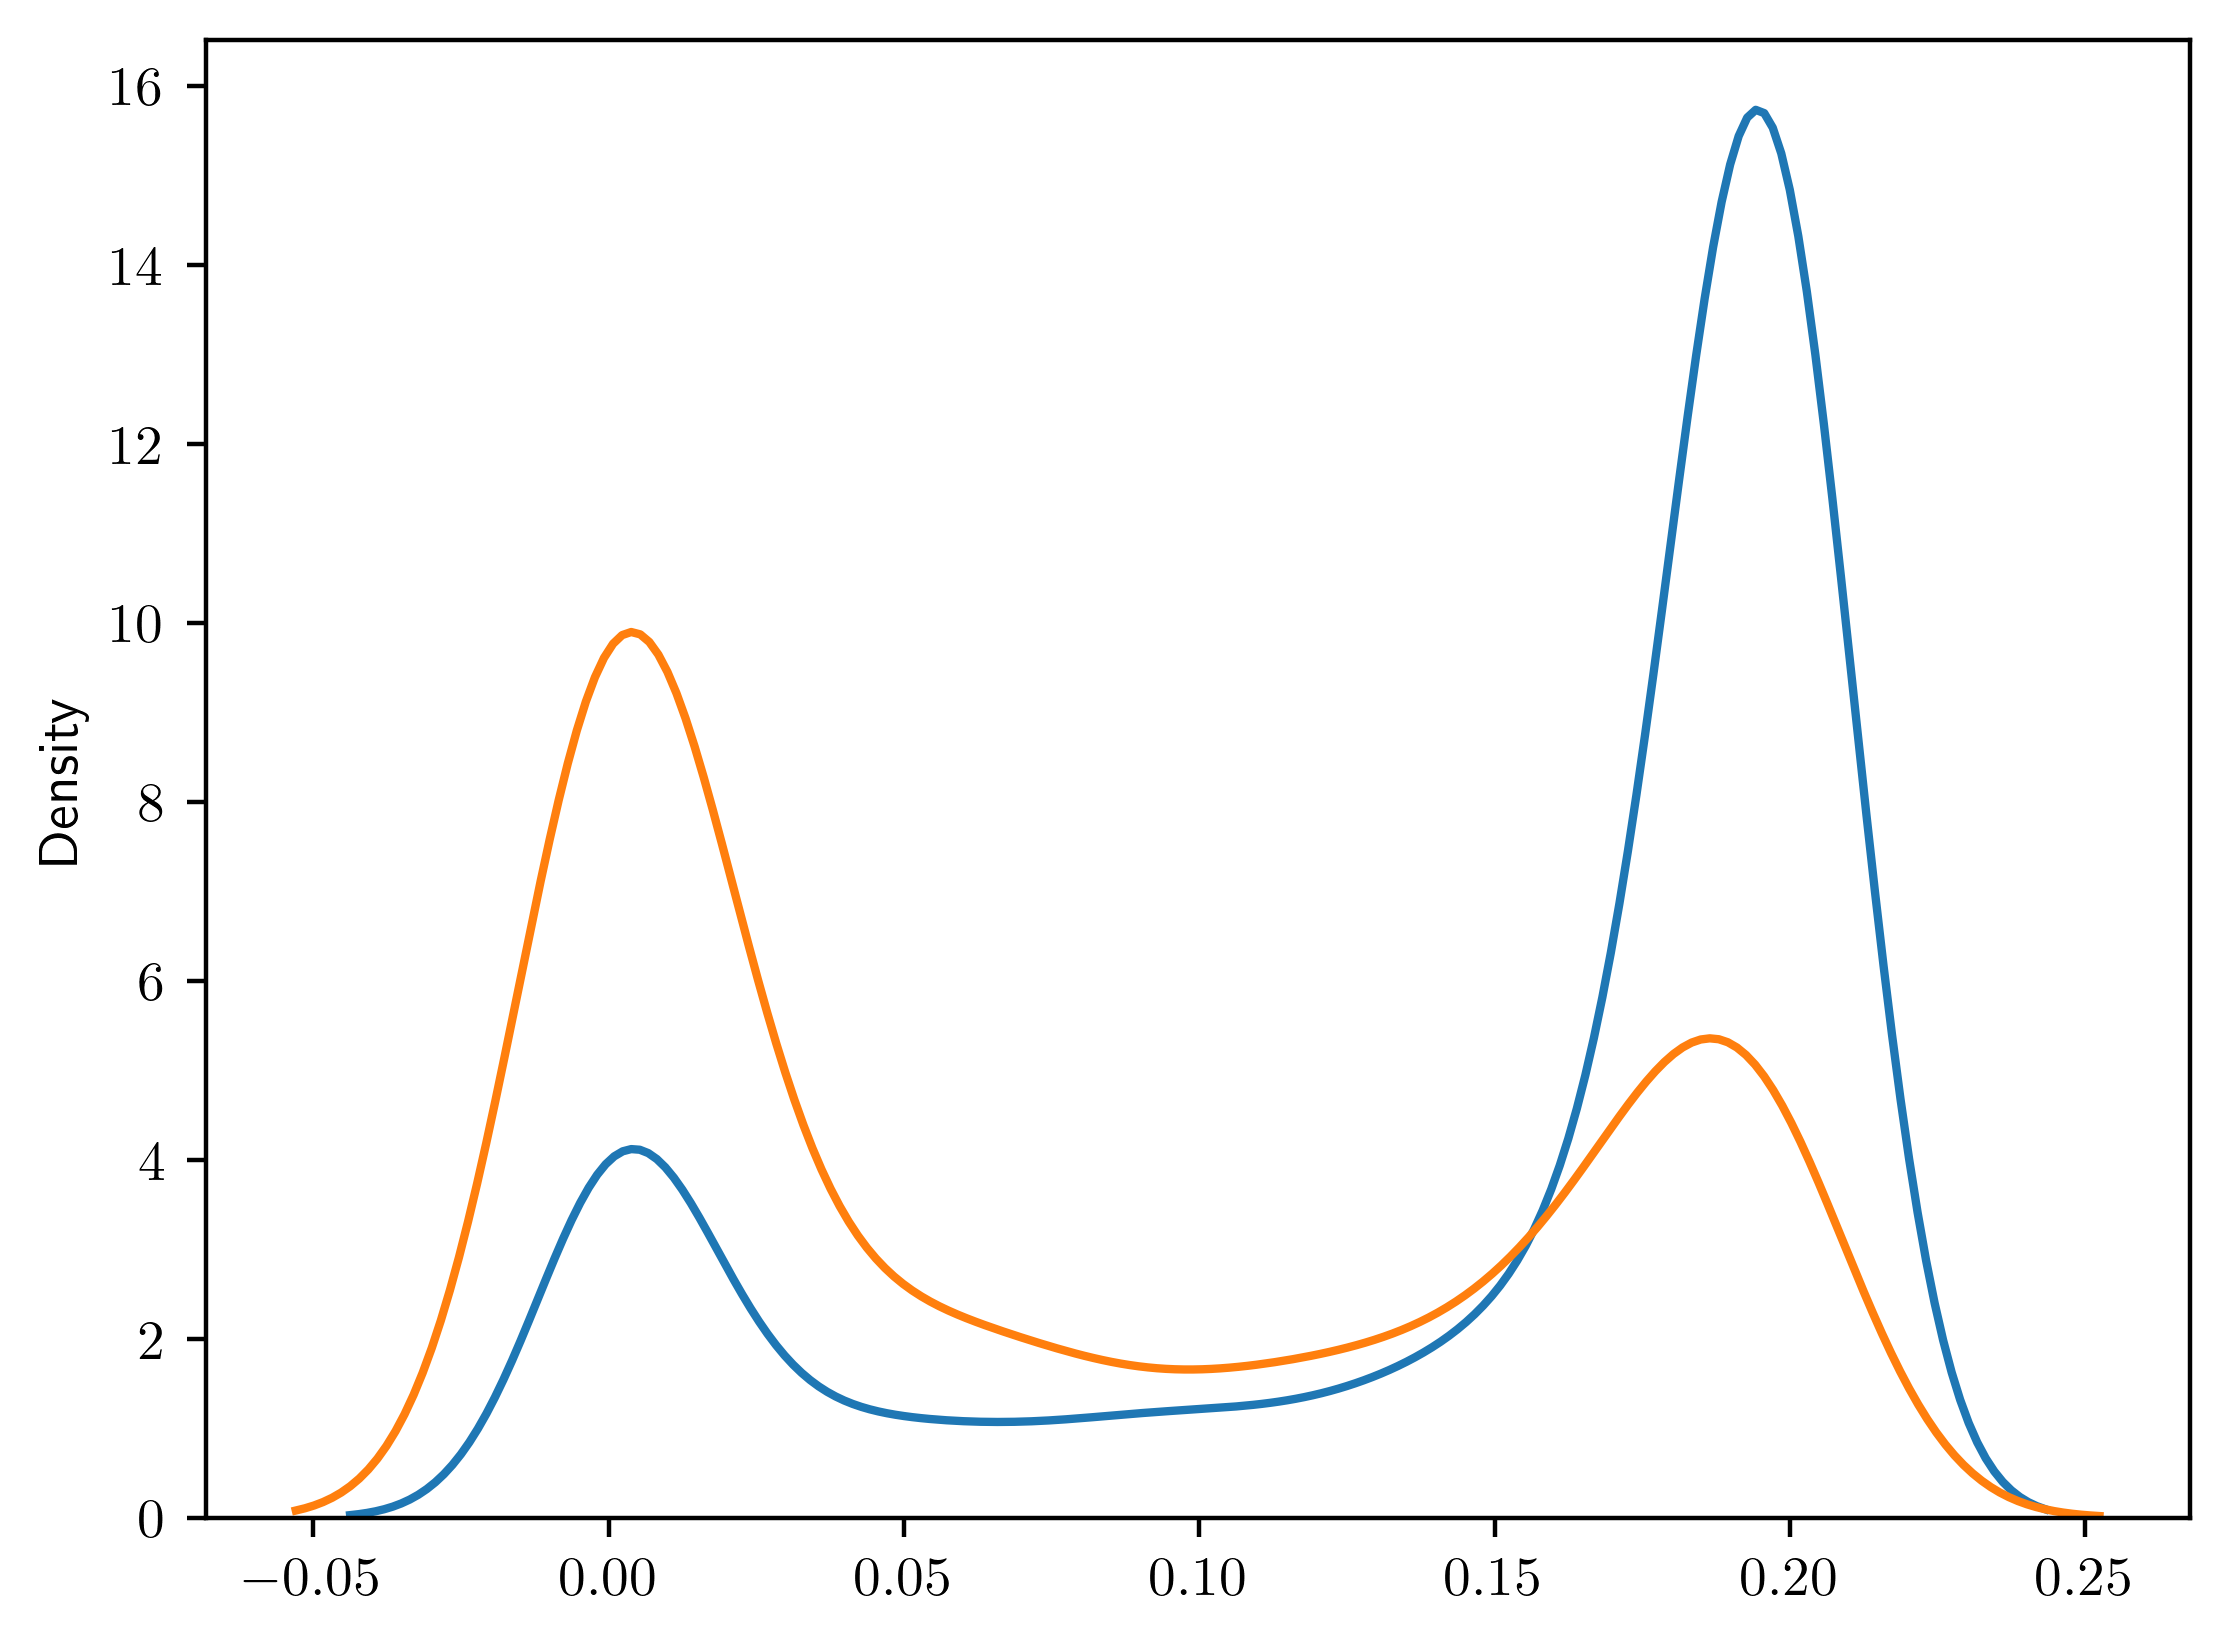

In [5]:
from utils.counting_utils import * 

out = get_scores_numbers(val_inf_out, cur_val_ds.Y,10)

sns.kdeplot(out['correct_scores'])
sns.kdeplot(out['incorrect_scores'])


In [6]:
dm.unmark_auto_labeled()

auto_labeler = AutoLabeling(conf,dm,pl.cur_clf,logger,calibrator=calib)
out = auto_labeler.run()
out = dm.get_auto_labeling_counts()
print(out)

[] [4, 7, 61, 62, 98, 103, 110, 116, 149, 158]
{'auto_labeled_acc': 0.941408302679979, 'coverage_1': 0.36247619047619045, 'coverage_2': 0}
